##### Copyright 2021 Bjorn Leon Neumann. (modified)
##### Copyright 2019 The TensorFlow Authors.

This notebook has been inspired by the "Basic text classification" tutorial https://www.tensorflow.org/tutorials/keras/text_classification offered by the TensorFlow Authors. Thus, some of the further explanations in this file stem from the TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Startup Pitchdeck Classification - Training/Testing/Exporting of Model

This notebook demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on custom startup data dataset..


In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Sentiment analysis

This notebook trains a sentiment analysis model to classify pitch decks as *positive* or *negative*, based on the text of the pitch deck. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

We are using a custom database that was created by downloading pitch decks from https://angelmatch.io/pitch_decks and extracting the text information using the PDFMiner package.

Our training dataset contains 176 pitch decks, of which 88 pitch decks are for training and 88 pitch decks are for testing. Furthermore, the training and testing sets are balanced. That means that an equal number of positive and negative pitch decks are contained in the training and testing sets.


### Download and explore the Pitch Deck dataset

Let's download and extract the dataset, then explore the directory structure.

To download the respective dataset, make sure to upload the "startup_data.tar.gz". You can do that by dropping the file in the files panel on the left side of the screen.

In [ ]:
url = "startup_data.tar.gz"

dataset = tf.keras.utils.get_file("startup_data", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'startup_data')

In [ ]:
os.listdir(dataset_dir)

['.txt', 'train', 'test', '.DS_Store']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg', 'pos', '.DS_Store']

The `startup_data/train/pos` and `startup_data/train/neg` directories contain many text files, each of which is a single pitch deck. Let's take a look at one of them.

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1huddle.txt')
with open(sample_file) as f:
  print(f.read())

   sales-huddle-group   GAMIFY SALES TRAINING TO BOOST SALES      51 CLIENTS. 10,000 USERS.!  sales-huddle-group   S P O R T S    E N T E R T A I N M E N T    C O L L E G E S       sales-huddle-group   2015 T O T A L   S A L E S   $204,000  $10K  $40K  69%   M o M   G R O W T H   NOV      DEC      JAN      FEB       $486B  C O R P   T R A I N I N G      BUILD  GAMES FOR TRAINING   sales-huddle-group      sales-huddle-group   PLAY  IN INDIVIDUAL OR TEAM MODE   HOW MANY GUEST PASSES DO  YOU RECEIVE PER YEAR?      REWARD  TOP PLAYERS   sales-huddle-group      sales-huddle-group   $15M QUESTION   THE TOTAL PRICE FOR  THIS SUPER BOWL 50  GAME DAY SUITE IS‚Ä¶   $1,000,000  $2,000,000     sales-huddle-group     $10M  I N C R E A S E   I N   S A L E S       TEAM  sales-huddle-group   SAM CAUCCI FOUNDER & CEO  10+ YEARS TRAINING SALES & SERVICE REPS   ROGER BERNARDINO DIRECTOR OF SALES 6 YEARS SELLING ENTERPRISE SAAS   BEN POWERS CLIENT SUCCESS MANAGER GAME BUILDING GURU     sales-hud

### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative pitch decks, which can be found in  `startup_data/train/pos` and `startup_data/train/neg`..

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The startup dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [ ]:
batch_size = 16 #2 and #6 also used before
seed = 425

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'startup_data/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 88 files belonging to 2 classes.
Using 71 files for training.


As you can see above, there are 88 examples in the training folder, of which you will use 80% (or 71) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(1):
    print("Pitch Deck", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Pitch Deck b'Coupons & Cashback App   for online shopping  \x0c    We are Growing  $300K  MONTHLY GMV  37%  MONTHLY GROWTH  3X  LTV/CAC  \x0c  The opportunity is BIG  Coupons & Cashback $10B  $$$  Indian e-commerce market $100B   $$$  \x0c    Customer Problem  Retailer Problem  How to find the best discounts   on mobile?  Very High Cost of Acquisition  \x0c    Making every penny count for our members  Savings  Destination  Transactions  Extra LafaLafa  Cashback  Commission  \x0c    Deals for everybody- Personal Deal Assistant   I want to buy an   iPhone  Best option is via Flipkart  \x0c    India  Hong Kong  Expanding in Asia  Indonesia  \x0c    The Team  Years of ecommerce & tech experience in startups Yosha Gupta, CEO & Founder, 10 years in mobile payments & fintech  \x0c  $300K  MONTHLY GMV  37%  MONTHLY GROWTH  3X  LTV/CAC    \x0c'
Label 0


Next, you will create a validation and test dataset. You will use the remaining 17 pitch decks from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'startup_data/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 88 files belonging to 2 classes.
Using 17 files for validation.


In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'startup_data/test', 
    batch_size=batch_size)

Found 88 files belonging to 2 classes.


Note: The Preprocessing APIs used in the following section are experimental in TensorFlow 2.3 and subject to change.

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `preprocessing.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

Some pitch decks may contain some HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: to prevent [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also know as train/serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this notebook.

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. you will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [ ]:
max_features = 4719
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 2 pitch decks and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_pitch_deck, first_label = text_batch[0], label_batch[0]
print("Pitch Deck", first_pitch_deck)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized pitch deck", vectorize_text(first_pitch_deck, first_label))

Pitch Deck tf.Tensor(b'Proofreading is Broken.  We just Solved it.  \x0c\x0c\x0c\xc3\x94\xc3\x87\xc3\x9f Cheesy stock photos \xc3\x94\xc3\x87\xc3\x9f Confusing price structure \xc3\x94\xc3\x87\xc3\x9f No transparency  \x0c\x0cUser uploads a paper  Purchase or earn credits  Proofread by another user  Admin quality review  \x0c\xc3\x94\xc3\x89\xc2\xba Proofread paper in < 24 hours  \x0c\xc3\x94\xc3\x89\xc2\xba Proprietary Application \xc3\x94\xc3\x89\xc2\xba Encourages Comments  \x0cTotal Users  Papers Proofread  Users Growing 44% W/W  Papers Proofread 40% W/W  2600 2400 2200 2000 1800 1600 1400 1200 1000 800 600 400 200 0  4/22 4/29 5/6 5/13 5/20 5/27 5/28 6/3 6/10 6/17 6/24 7/1 7/8 7/15 7/22 7/29 8/5 8/12  We have paid users!  80% of Users are Students  \x0c31 Million Students in the U.S.  Writing 30 papers per year  930 Million papers need proofreading each year  \x0cTeam  Travis Biziorek  \xe2\x80\x9a\xc3\x84\xc2\xa2 Financial analyst (Charles Schwab)  \xe2\x80\x9a\xc3\x84\xc2\xa2 Cu

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [ ]:
print("18 ---> ",vectorize_layer.get_vocabulary()[18])
print(" 865 ---> ",vectorize_layer.get_vocabulary()[865])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

18 --->  l
 865 --->  host
Vocabulary size: 4186


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create our neural network:

In [ ]:
embedding_dim = 512 # Checked for 8, 16, 32, 64, 128, 256, 512

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 512)         2416640   
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 2,417,153
Trainable params: 2,417,153
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded pitch decks and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, see the [word embedding tutorial](../text/word_embeddings.ipynb).
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
5/5 [==============================] - 1s 75ms/step - loss: 0.6921 - binary_accuracy: 0.4904 - val_loss: 0.6911 - val_binary_accuracy: 0.5294
Epoch 2/10
5/5 [==============================] - 0s 41ms/step - loss: 0.6758 - binary_accuracy: 0.6503 - val_loss: 0.6906 - val_binary_accuracy: 0.5294
Epoch 3/10
5/5 [==============================] - 0s 46ms/step - loss: 0.6652 - binary_accuracy: 0.6767 - val_loss: 0.6908 - val_binary_accuracy: 0.5294
Epoch 4/10
5/5 [==============================] - 0s 41ms/step - loss: 0.6549 - binary_accuracy: 0.7035 - val_loss: 0.6912 - val_binary_accuracy: 0.5294
Epoch 5/10
5/5 [==============================] - 0s 41ms/step - loss: 0.6442 - binary_accuracy: 0.7082 - val_loss: 0.6917 - val_binary_accuracy: 0.5294
Epoch 6/10
5/5 [==============================] - 0s 42ms/step - loss: 0.6336 - binary_accuracy: 0.7242 - val_loss: 0.6922 - val_binary_accuracy: 0.5294
Epoch 7/10
5/5 [==============================] - 0s 43ms/step - loss: 0.6213 - bi

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

6/6 [==============================] - 0s 4ms/step - loss: 0.6633 - binary_accuracy: 0.6136
Loss:  0.6632837057113647
Accuracy:  0.6136363744735718


This fairly naive approach achieves an accuracy of about 60%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

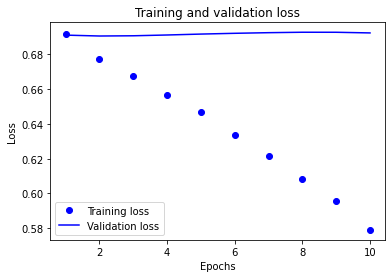

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

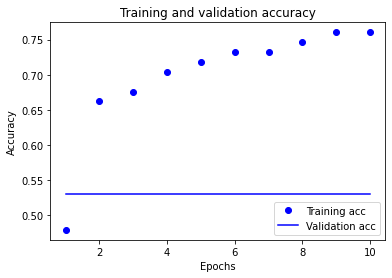

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)



# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

6/6 [==============================] - 0s 6ms/step - loss: 0.6790 - accuracy: 0.5936
0.6136363744735718


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Calling `save('my_model')` creates a SavedModel folder `my_model`.
export_model.save("my_model")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("my_model", custom_objects={'TextVectorization':TextVectorization, 
                    'custom_standardization':custom_standardization})

examples = [
  "We offer the best services ever! And we have a great team as well!",
  "This Sales Pipeline Process Template is a step-by-step workflow  that enhances your team‚Äôs focus and productivity by guiding them  through all the steps of the sale",
  "with a natural ability to perform and realize how to help develop them into great leaders.Decode the complexities and realize what drives workplace behaviors so you can ensure alignment, reach your team‚Äôs true potential, and achieve your business objectives faster than you ever thought possible, all with The Predictive Index¬Æ.&PROBLEMS WE SOLVEThe Predictive Index uses the power of Science and Technology to deliver solutions"
]

reconstructed_model.predict(examples)

INFO:tensorflow:Assets written to: my_model/assets


array([[0.3302916 ],
       [0.3511087 ],
       [0.40599695]], dtype=float32)

# Downloading the model to one's local machine
With the following command, we convert our exported model into a zip file. This enables us to download the model and use it in our pitch deck evaluation software.

After downloading the file to one's local machine, one can unzip it and use it in one's software.

In [ ]:
!zip -r ./my_model.zip ./my_model/

  adding: my_model/ (stored 0%)
  adding: my_model/variables/ (stored 0%)
  adding: my_model/variables/variables.data-00000-of-00001 (deflated 27%)
  adding: my_model/variables/variables.index (deflated 61%)
  adding: my_model/saved_model.pb (deflated 91%)
  adding: my_model/assets/ (stored 0%)


Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.